In [135]:
import gensim.downloader as api
model_glove = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [157]:
import pandas as pd
from nltk import word_tokenize
from sklearn.metrics import accuracy_score
from keras.preprocessing import sequence
from keras.layers import Input, Dense, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
import numpy as np
df = pd.read_csv('cleaned_stock_trend.csv')


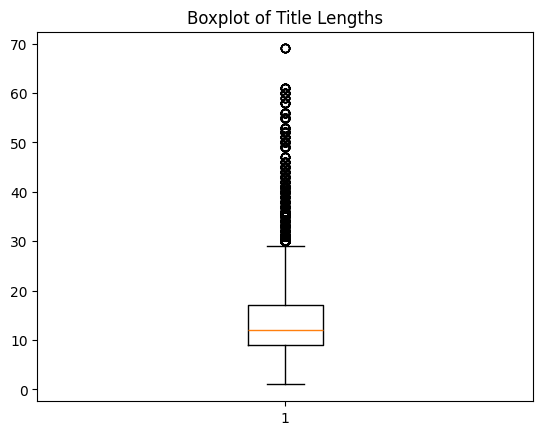

In [158]:
# Ge the boxplot for sentence lengths
df['Title_Tokenized'] = df['Title'].apply(word_tokenize)
df['Title_Len'] = df['Title_Tokenized'].apply(len)
import matplotlib.pyplot as plt
plt.boxplot(df['Title_Len'])
plt.title('Boxplot of Title Lengths')
plt.show()  

In [159]:
# Average length
avg_len = int(df['Title_Len'].mean())
print(f'Average Title Length: {avg_len}')

Average Title Length: 14


In [165]:
sent_length = 14
n_features = 100
n_outputs = 3
batch_size = 64
epochs = 20


docs_embedding = list()
for doc in df['Title']:
    tokens = word_tokenize(doc.lower())
    # To handle OOV words, we use try-except block
    for i in range(len(tokens)):
        try:
            model_glove[tokens[i]]
        except KeyError:
            tokens[i] = 'unk'  # Replace OOV word with 'unk'
    embedding = model_glove[tokens]
    docs_embedding.append(embedding)
    print(f"Processed document: {doc}")
    
# Pad embedding sequence so that each document has the same length
from keras.preprocessing.sequence import pad_sequences
X = sequence.pad_sequences(docs_embedding, maxlen=sent_length, dtype='int32')
X = np.array(X)
print(X.shape)

Processed document: 100 startups participate in Maxis' Market Access Day
Processed document: 16.89% stake in Subur Tiasa traded off-market
Processed document: Najib wanted 1MDB's Genting Sanyen deal sped up on fears caretaker govt couldn't approve it – witness
Processed document: 25bps OPR cut likely in 2H20, says Manulife
Processed document: A 25-month extension on concession pushes Pharmaniaga up by 9.7%
Processed document: 3.7% of Yong Tai transacted off-market
Processed document: 3A, Ruberex, Thriven, Kanger, UniWall
Processed document: 40% stake in IWH-CREC may cost Ekovest RM1.5b
Processed document: 4.41% Kronologi Asia shares traded off-market
Processed document: 4.96% of MMAG traded off market
Processed document: A 4.96% stake in Media Prima crosses off market at same price paid by Syed Mokhtar
Processed document: 5.71% of Sern Kou Resources traded in two off-market deals
Processed document: 5.9% stake in Jiankun International traded off market
Processed document: 6% stake in G

In [166]:
# Train Test Split
from sklearn.model_selection import train_test_split
y = to_categorical(df['Trend_Label'], num_classes=n_outputs)
# Train 70%, Validation 20%, Test 10%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)
print(f'Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')
# Print each set label count for each set
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("y_train label count:")
print(pd.Series(y_train_labels).value_counts())
print("\ny_val label count:")
print(pd.Series(y_val_labels).value_counts())
print("\ny_test label count:")
print(pd.Series(y_test_labels).value_counts())


Train set: (17071, 14, 100), Validation set: (4878, 14, 100), Test set: (2439, 14, 100)
y_train label count:
0    15844
2      871
1      356
Name: count, dtype: int64

y_val label count:
0    4519
2     237
1     122
Name: count, dtype: int64

y_test label count:
0    2263
2     124
1      52
Name: count, dtype: int64


## **Step 3: LSTM Model Training & Prediction**

In Step 3, the LSTM model is constructed, trained, and used for prediction. The predicted labels are then compared to the true labels to evaluate model performance.

In [167]:
# Define the LSTM layer for computation
inputs = Input(shape = (sent_length, n_features))
lstm = LSTM(2, return_sequences = True, return_state = True)
outputs_seq, state_h, state_c = lstm(inputs)
flat = Flatten()(outputs_seq)
outputs = Dense(n_outputs, activation = 'softmax')(flat)

# Wrap the LSTM layer into a Keras model, connecting the input and output layers to form a single end-to-end model
model = Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

# Train the keras model
model.fit(X_train, y_train, validation_data = (X_val, y_val), 
          epochs = epochs, verbose = 1, batch_size = batch_size)

# Evaluate the keras model
prob = model.predict(X_test)
test = np.argmax(prob, axis = 1)

print(f"\nPrediction Probability:\n{prob}")
print(f"\nPredicted Class Label: {test}")
accuracy = accuracy_score(np.argmax(y_test, axis=1), test)
print(f"\nTest Accuracy: {accuracy}")

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 14, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ [(None, 14, 2), (None, │           824 │
│                                 │ 2), (None, 2)]         │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            87 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 911 (3.56 KB)

 Trainable params: 911 (3.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9004 - loss: 0.4325 - val_accuracy: 0.9264 - val_loss: 0.3191
Epoch 2/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.3064 - val_accuracy: 0.9264 - val_loss: 0.3078
Epoch 3/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.2988 - val_accuracy: 0.9264 - val_loss: 0.3040
Epoch 4/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.2956 - val_accuracy: 0.9264 - val_loss: 0.3017
Epoch 5/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.2929 - val_accuracy: 0.9264 - val_loss: 0.3012
Epoch 6/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.2911 - val_accuracy: 0.9264 - val_loss: 0.2988
Epoch 7/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.2896 - val_accuracy: 0.9264 - val_loss: 0.2991
Epoch 8/20
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.2876 - val_accuracy: 0.

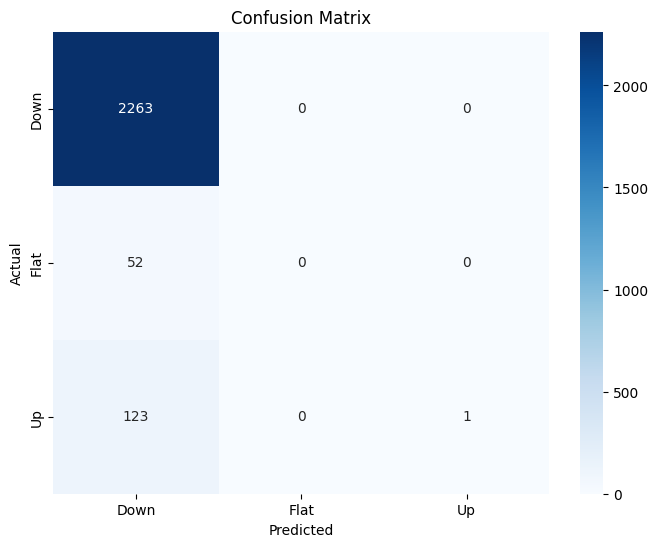


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2263
           1       0.00      0.00      0.00        52
           2       1.00      0.01      0.02       124

    accuracy                           0.93      2439
   macro avg       0.64      0.34      0.33      2439
weighted avg       0.91      0.93      0.89      2439



c:\Users\cch\Desktop\Y3S1\CPC353\assgn2\353as2\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\cch\Desktop\Y3S1\CPC353\assgn2\353as2\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\cch\Desktop\Y3S1\CPC353\assgn2\353as2\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

In [168]:
# Print Confusion Matrix as heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Flat', 'Up'], yticklabels=['Down', 'Flat', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Print Score
from sklearn.metrics import classification_report
report = classification_report(np.argmax(y_test, axis=1), test)
print(f"\nClassification Report:\n{report}")


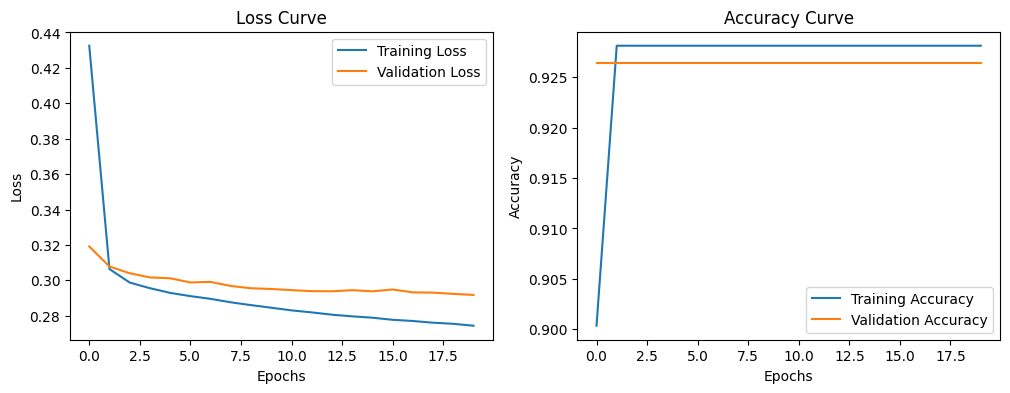

In [169]:
# plot loss and accuracy curves
history = model.history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()